# GARCH Model Testing

In [54]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import itertools
import matplotlib.pyplot as plt
import sklearn
from statsmodels.tsa.stattools import adfuller
from arch import arch_model
from sklearn.preprocessing import StandardScaler


In [55]:
# Load data
df = pd.read_excel('data/Monthly Mastersheet.xlsx')
print(df.head())
print(df.columns.tolist())

# Ensure date is datetime and set index
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)
df.index = pd.date_range(start=df.index[0], periods=len(df), freq='MS')
df.columns = df.columns.str.strip()

       Month   Bitcoin   Tether  Litecoin       XRP  Ethereum  Dogecoin  \
0 2017-09-01 -1.398923 -3.82830  -1.02849 -0.898590 -1.320943 -1.405018   
1 2017-10-01 -1.339539 -3.73861  -0.77151 -1.145490 -0.837982 -0.464897   
2 2017-11-01 -1.622995 -4.01951  -1.44830 -1.192080 -1.837874 -1.371050   
3 2017-12-01 -1.267670 -2.55687  -1.11575 -1.254630 -1.310402 -0.702095   
4 2018-01-01 -0.892511 -2.75193  -0.24164  0.038975 -0.811280 -0.334438   

   Cardano  USD Coin    VIX   MOVE  LFPR      CPI     r      M1    GDP  \
0      NaN       NaN  10.59  52.88  63.1  246.819  1.15  3535.6  60099   
1      NaN       NaN   9.51  51.15  62.7  246.663  1.15  3615.0  60674   
2      NaN       NaN  10.18  46.83  62.7  246.669  1.16  3587.6  60674   
3      NaN       NaN  11.28  46.60  62.7  246.524  1.30  3630.5  60674   
4      NaN       NaN  11.04  57.20  62.7  247.867  1.41  3673.4  61093   

         IM        EX     CC  CC Monthly % Change  Bitcoin Price  GDP Monthly  \
0  2916.022  2535.501  

## Testing all combinations

In [56]:
macro_list = ['PC1_macro', 'PC2_macro']
asset_list= ['Bitcoin', 'Tether', 'Litecoin', 'XRP', 'Ethereum', 'Dogecoin', 'Cardano', 'USD Coin','Bitcoin Price']
train_end = '2023-05-01'

results_list = []

In [57]:
# Pre-difference all macro variables
for macro in macro_list:
    adf_p = adfuller(df[macro].dropna())[1]
    if adf_p > 0.05:
        df[f'{macro}_diff'] = df[macro].diff()
        adf_p = adfuller(df[f'{macro}_diff'].dropna())[1]
        if adf_p > 0.05:
            df[f'{macro}_diff_diff'] = df[f'{macro}_diff'].diff()

## Forecasting Macro Mean, p-value, just based on (1,1)

In [58]:
import pandas as pd
import numpy as np
from arch import arch_model
from sklearn.preprocessing import StandardScaler

results = []

for macro in macro_list:
    if f'{macro}_diff_diff' in df.columns:
        y_col = f'{macro}_diff_diff'
    elif f'{macro}_diff' in df.columns:
        y_col = f'{macro}_diff'
    else:
        y_col = macro

    for asset in asset_list:
        df_temp = df[[y_col, asset]].dropna().copy()
        if len(df_temp) < 30:
            print(f"Skipping {macro}-{asset}: insufficient data ({len(df_temp)})")
            continue

        y_var = df_temp[y_col].var()
        x_var = df_temp[asset].var()
        if y_var == 0 or x_var == 0:
            print(f"Skipping {macro}-{asset}: zero variance in y or x")
            continue

        scaler_y = StandardScaler()
        scaler_x = StandardScaler()

        y_scaled = scaler_y.fit_transform(df_temp[[y_col]]).flatten()
        x_scaled = scaler_x.fit_transform(df_temp[[asset]])

        try:
            model = arch_model(
                y_scaled,
                mean='ARX',
                lags=1,
                vol='GARCH',
                p=1,
                q=1,
                x=x_scaled,
                dist='normal'
            )
            res = model.fit(disp='off')

            # Collect exogenous regressor results, if present
            exog_params = [p for p in res.params.index if p.startswith('x')]
            if exog_params:
                for p_name in exog_params:
                    results.append({
                        'Macro': macro,
                        'Macro_col': y_col,
                        'Crypto': asset,
                        'Param': p_name,
                        'Coef': res.params[p_name],
                        'P-value': res.pvalues[p_name],
                        'AIC': res.aic,
                        'BIC': res.bic,
                        'Model_Success': True,
                    })
            else:
                # No exogenous regressor included
                results.append({
                    'Macro': macro,
                    'Macro_col': y_col,
                    'Crypto': asset,
                    'Param': None,
                    'Coef': np.nan,
                    'P-value': np.nan,
                    'AIC': res.aic,
                    'BIC': res.bic,
                    'Model_Success': True,
                })

            # print(f"Model fit successful for {macro}-{asset}")

        except Exception as e:
            print(f"Error fitting model for {macro}-{asset}: {e}")
            results.append({
                'Macro': macro,
                'Macro_col': y_col,
                'Crypto': asset,
                'Param': None,
                'Coef': np.nan,
                'P-value': np.nan,
                'AIC': np.nan,
                'BIC': np.nan,
                'Model_Success': False,
            })

# After loop, build and display results DataFrame
results_df = pd.DataFrame(results)

# Display full DataFrame without truncation
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

display(results_df.sort_values(by=['P-value'], na_position='last'))


,Macro,Macro_col,Crypto,Param,Coef,P-value,AIC,BIC,Model_Success
14,PC2_macro,PC2_macro_diff,Dogecoin,x0,0.152917,0.000071,125.283127,140.078576,True
13,PC2_macro,PC2_macro_diff,Ethereum,x0,0.085947,0.020897,139.550385,154.345833,True
0,PC1_macro,PC1_macro_diff,Bitcoin,x0,0.093227,0.028001,257.609021,272.404470,True
9,PC2_macro,PC2_macro_diff,Bitcoin,x0,0.066576,0.033956,141.686118,156.481567,True
6,PC1_macro,PC1_macro_diff,Cardano,x0,0.061088,0.036688,247.886069,262.399112,True
4,PC1_macro,PC1_macro_diff,Ethereum,x0,0.117223,0.060417,257.207338,272.002787,True
16,PC2_macro,PC2_macro_diff,USD Coin,x0,0.025694,0.181372,128.738757,142.398753,True
15,PC2_macro,PC2_macro_diff,Cardano,x0,0.066546,0.186586,139.793389,154.306433,True
11,PC2_macro,PC2_macro_diff,Litecoin,x0,0.051401,0.204478,143.789130,158.584579,True
8,PC1_macro,PC1_macro_diff,Bitcoin Price,x0,-0.066327,0.350251,257.941748,272.737197,True


In [59]:
def plot_actual_vs_predicted(df, macro, asset, res):
    from sklearn.preprocessing import StandardScaler
    import matplotlib.pyplot as plt

    # Determine differenced macro column used
    if f'{macro}_diff_diff' in df.columns:
        y_col = f'{macro}_diff_diff'
    elif f'{macro}_diff' in df.columns:
        y_col = f'{macro}_diff'
    else:
        y_col = macro

    df_temp = df[[y_col, asset]].dropna().copy()

    # Scale the data
    scaler_y = StandardScaler()
    scaler_x = StandardScaler()
    y_scaled = scaler_y.fit_transform(df_temp[[y_col]]).flatten()
    x_scaled = scaler_x.fit_transform(df_temp[[asset]]).flatten()

    # Align for ARX(1): y[t] = const + phi*y[t-1] + beta*x[t]
    y_lag = y_scaled[:-1]
    x_current = x_scaled[1:]
    predicted_mean_scaled = (
        res.params['Const']
        + res.params['y[1]'] * y_lag
        + res.params.get('x0', 0) * x_current
    )

    # Actual y from t=1 onward
    y_actual_scaled = y_scaled[1:]

    # Inverse transform to original scale
    predicted_mean = scaler_y.inverse_transform(predicted_mean_scaled.reshape(-1, 1)).flatten()
    y_actual = scaler_y.inverse_transform(y_actual_scaled.reshape(-1, 1)).flatten()

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(df_temp.index[-len(predicted_mean):], y_actual, label='Actual', marker='o')
    plt.plot(df_temp.index[-len(predicted_mean):], predicted_mean, label='Predicted Mean', linestyle='--', marker='x')
    plt.title(f'Actual vs Predicted {y_col} using {asset} in GARCH Mean')
    plt.xlabel('Date')
    plt.ylabel(y_col)
    plt.legend()
    plt.show()

    from sklearn.metrics import mean_squared_error, r2_score

    r2 = r2_score(y_actual, predicted_mean)
    mse = mean_squared_error(y_actual, predicted_mean)

    print(f"R²: {r2:.4f}, MSE: {mse:.4f}")


In [60]:
def plot_actual_vs_predicted_with_baseline(df, macro, asset, res):
    from sklearn.preprocessing import StandardScaler
    import matplotlib.pyplot as plt
    from sklearn.metrics import mean_squared_error, r2_score
    from arch import arch_model

    # Determine differenced macro column used
    if f'{macro}_diff_diff' in df.columns:
        y_col = f'{macro}_diff_diff'
    elif f'{macro}_diff' in df.columns:
        y_col = f'{macro}_diff'
    else:
        y_col = macro

    df_temp = df[[y_col, asset]].dropna().copy()

    # Scale the data
    scaler_y = StandardScaler()
    scaler_x = StandardScaler()
    y_scaled = scaler_y.fit_transform(df_temp[[y_col]]).flatten()
    x_scaled = scaler_x.fit_transform(df_temp[[asset]]).flatten()

    # ---------- ARX(1) model predictions (with crypto) ----------
    y_lag = y_scaled[:-1]
    x_current = x_scaled[1:]
    predicted_arx_scaled = (
        res.params['Const']
        + res.params['y[1]'] * y_lag
        + res.params.get('x0', 0) * x_current
    )
    y_actual_scaled = y_scaled[1:]

    predicted_arx = scaler_y.inverse_transform(predicted_arx_scaled.reshape(-1, 1)).flatten()
    y_actual = scaler_y.inverse_transform(y_actual_scaled.reshape(-1, 1)).flatten()

    # ---------- AR(1) baseline model (no crypto) ----------
    model_ar = arch_model(y_scaled, mean='AR', lags=1, vol='GARCH', p=1, q=1, dist='normal')
    res_ar = model_ar.fit(disp="off")
    predicted_ar_scaled = res_ar.params['Const'] + res_ar.params['y[1]'] * y_scaled[:-1]
    predicted_ar = scaler_y.inverse_transform(predicted_ar_scaled.reshape(-1, 1)).flatten()

    # Align everything to same length
    y_actual_plot = y_actual[-len(predicted_ar):]
    predicted_arx_plot = predicted_arx[-len(predicted_ar):]

    # ---------- Plot ----------
    idx = df_temp.index[-len(predicted_ar):]

    plt.figure(figsize=(10, 6))
    plt.plot(idx, y_actual_plot, label='Actual', marker='o',markersize=1)
    plt.plot(idx, predicted_ar, label='Predicted AR(1) GARCH ', linestyle='--', marker='x',markersize=1)
    plt.plot(idx, predicted_arx_plot, label=f'Predicted ARX(1) GARCH + {asset}', linestyle='--', marker='s',markersize=1)
    plt.title(f'Actual vs Predicted {y_col} with and without {asset}')
    plt.xlabel('Date')
    plt.ylabel(y_col)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ---------- Metrics ----------
    print("Model Comparison Metrics:")
    print(f"{'Metric':<10} | {'AR(1)':<12} | {'ARX + ' + asset:<15}")
    print("-" * 40)
    print(f"{'R²':<10} | {r2_score(y_actual_plot, predicted_ar):<12.4f} | {r2_score(y_actual_plot, predicted_arx_plot):<15.4f}")
    print(f"{'MSE':<10} | {mean_squared_error(y_actual_plot, predicted_ar):<12.4f} | {mean_squared_error(y_actual_plot, predicted_arx_plot):<15.4f}")


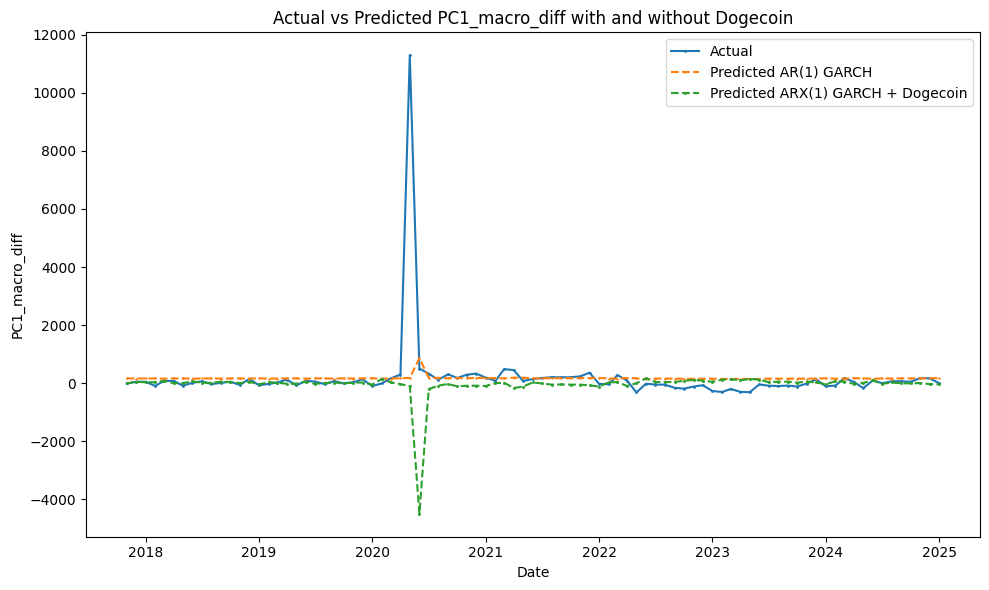

Model Comparison Metrics:
Metric     | AR(1)        | ARX + Dogecoin 
----------------------------------------
R²         | 0.0038       | -0.2441        
MSE        | 1460160.8483 | 1823500.6414   


In [77]:
# replace this with pairs as needed
# plot_actual_vs_predicted(df, 'GDP Monthly', 'USD coin', res)
plot_actual_vs_predicted_with_baseline(df, 'PC1_macro', 'Dogecoin', res)

## Metrics table, just (1,1)

In [62]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
import numpy as np

metrics = []

# Filter only successful models with valid exogenous terms
for row in results_df.dropna(subset=['Coef']).itertuples():
    macro = row.Macro
    macro_col = row.Macro_col
    asset = row.Crypto

    df_temp = df[[macro_col, asset]].dropna().copy()
    if len(df_temp) < 30:
        continue

    # Standardize
    scaler_y = StandardScaler()
    scaler_x = StandardScaler()
    y_scaled = scaler_y.fit_transform(df_temp[[macro_col]]).flatten()
    x_scaled = scaler_x.fit_transform(df_temp[[asset]]).flatten()

    try:
        # Refit AR(1)
        model_ar = arch_model(y_scaled, mean='AR', lags=1, vol='GARCH', p=1, q=1, dist='normal')
        res_ar = model_ar.fit(disp='off')
        pred_ar_scaled = res_ar.params['Const'] + res_ar.params['y[1]'] * y_scaled[:-1]
        y_actual_ar_scaled = y_scaled[1:]
        pred_ar = scaler_y.inverse_transform(pred_ar_scaled.reshape(-1, 1)).flatten()
        y_actual_ar = scaler_y.inverse_transform(y_actual_ar_scaled.reshape(-1, 1)).flatten()

        # Refit ARX(1)
        model_arx = arch_model(y_scaled, mean='ARX', lags=1, vol='GARCH', p=1, q=1, x=x_scaled, dist='normal')
        res_arx = model_arx.fit(disp='off')
        pred_arx_scaled = (
            res_arx.params['Const']
            + res_arx.params['y[1]'] * y_scaled[:-1]
            + res_arx.params.get('x0', 0) * x_scaled[1:]
        )
        pred_arx = scaler_y.inverse_transform(pred_arx_scaled.reshape(-1, 1)).flatten()
        y_actual_arx = scaler_y.inverse_transform(y_scaled[1:].reshape(-1, 1)).flatten()

        # Metrics
        metrics.append({
            'Macro': macro,
            'Crypto': asset,
            'MSE_AR': mean_squared_error(y_actual_ar, pred_ar),
            'MSE_ARX': mean_squared_error(y_actual_arx, pred_arx),
            'RMSE_AR': np.sqrt(mean_squared_error(y_actual_ar, pred_ar)),
            'RMSE_ARX': np.sqrt(mean_squared_error(y_actual_arx, pred_arx)),
            'R2_AR': r2_score(y_actual_ar, pred_ar),
            'R2_ARX': r2_score(y_actual_arx, pred_arx),
            'MAPE_AR': mean_absolute_percentage_error(y_actual_ar, pred_ar),
            'MAPE_ARX': mean_absolute_percentage_error(y_actual_arx, pred_arx),
            'MSE_Diff': mean_squared_error(y_actual_ar, pred_ar) - mean_squared_error(y_actual_arx, pred_arx)
        })

    except Exception as e:
        print(f"Skipping {macro}-{asset} in metrics due to error: {e}")

# Build and show
metrics_df = pd.DataFrame(metrics)

# Optional: sort by improvement (e.g. MSE reduction)
metrics_df_sorted = metrics_df.sort_values(by='MSE_Diff', ascending=False)

# Show key results
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
display(metrics_df_sorted)


,Macro,Crypto,MSE_AR,MSE_ARX,RMSE_AR,RMSE_ARX,R2_AR,R2_ARX,MAPE_AR,MAPE_ARX,MSE_Diff
14,PC2_macro,Dogecoin,1.706383e+05,7.943941e+04,413.083835,281.849981,-0.936521,0.098467,2.830864,2.725948,91198.842762
4,PC1_macro,Ethereum,1.460161e+06,1.439309e+06,1208.371155,1199.711853,0.003832,0.018058,5.417290,4.913338,20852.318388
0,PC1_macro,Bitcoin,1.460161e+06,1.446203e+06,1208.371155,1202.581837,0.003832,0.013354,5.417290,4.123361,13957.773783
6,PC1_macro,Cardano,1.531000e+06,1.523590e+06,1237.335870,1234.337816,0.002399,0.007228,4.308326,4.884814,7410.211838
8,PC1_macro,Bitcoin Price,1.460161e+06,1.453206e+06,1208.371155,1205.489835,0.003832,0.008577,5.417290,4.727117,6955.105426
9,PC2_macro,Bitcoin,1.706383e+05,1.644447e+05,413.083835,405.517843,-0.936521,-0.866232,2.830864,3.035005,6193.534117
13,PC2_macro,Ethereum,1.706383e+05,1.645832e+05,413.083835,405.688573,-0.936521,-0.867804,2.830864,2.952121,6055.036246
7,PC1_macro,USD Coin,1.757407e+06,1.752993e+06,1325.672184,1324.006523,0.003479,0.005982,6.611860,6.633499,4413.467299
15,PC2_macro,Cardano,1.781710e+05,1.744875e+05,422.103126,417.717005,-0.933951,-0.893968,2.986847,3.105077,3683.552909
5,PC1_macro,Dogecoin,1.460161e+06,1.456895e+06,1208.371155,1207.018861,0.003832,0.006060,5.417290,5.665446,3266.317358


## Test & Train

Evaluation on Test Set (PC1_macro-Dogecoin):
p = 1, q = 1
R²: -5.4166
MSE: 71993.0290
RMSE: 268.3152
MAPE: 18.6691


/Users/tianyishen/Desktop/CSUREMM project/CryptoMacroecon-Prediction-CSUREMM-1/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/tianyishen/Desktop/CSUREMM project/CryptoMacroecon-Prediction-CSUREMM-1/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


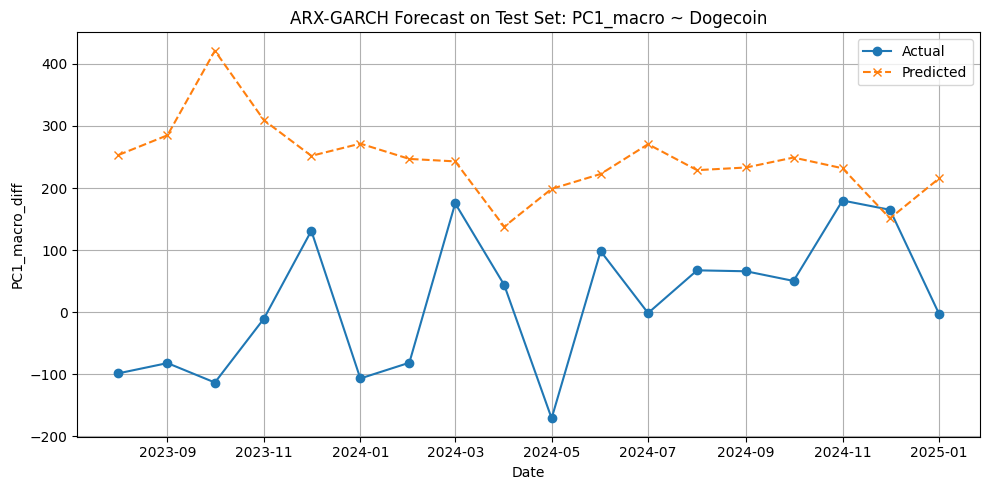

In [78]:
def evaluate_arx_garch_train_test(df, macro, asset, test_size=0.2, max_pq=3):
    # Use differenced macro if present
    if f'{macro}_diff_diff' in df.columns:
        y_col = f'{macro}_diff_diff'
    elif f'{macro}_diff' in df.columns:
        y_col = f'{macro}_diff'
    else:
        y_col = macro

    df_temp = df[[y_col, asset]].dropna().copy()
    if len(df_temp) < 50:
        print(f"Not enough data for {macro}-{asset}")
        return

    # Train-test split
    split_idx = int(len(df_temp) * (1 - test_size))
    df_train = df_temp.iloc[:split_idx]
    df_test = df_temp.iloc[split_idx:]

    # Scale data
    scaler_y = StandardScaler()
    scaler_x = StandardScaler()
    y_train_scaled = scaler_y.fit_transform(df_train[[y_col]]).flatten()
    x_train_scaled = scaler_x.fit_transform(df_train[[asset]]).flatten()

    # Grid search for best (p, q) on training set
    best_aic = np.inf
    best_model = None
    best_pq = (1, 1)

    for p in range(1, max_pq + 1):
        for q in range(1, max_pq + 1):
            try:
                model = arch_model(
                    y_train_scaled,
                    mean='ARX',
                    lags=1,
                    vol='GARCH',
                    p=p,
                    q=q,
                    x=x_train_scaled,
                    dist='normal'
                )
                res = model.fit(disp='off')
                if res.aic < best_aic:
                    best_aic = res.aic
                    best_model = res
                    best_pq = (p, q)
            except:
                continue

    if best_model is None:
        print(f"Model fitting failed for {macro}-{asset}")
        return

    # Forecasting
    y_test = df_test[[y_col]].values.flatten()
    x_test = df_test[[asset]].values.flatten()

    y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()
    x_test_scaled = scaler_x.transform(x_test.reshape(-1, 1)).flatten()

    y_train_last = y_train_scaled[-1]
    preds_scaled = []
    for t in range(len(y_test_scaled)):
        y_lag = preds_scaled[-1] if preds_scaled else y_train_last
        x_now = x_test_scaled[t]
        pred = (
            best_model.params['Const']
            + best_model.params['y[1]'] * y_lag
            + best_model.params.get('x0', 0) * x_now
        )
        preds_scaled.append(pred)

    preds_scaled = np.array(preds_scaled)
    preds = scaler_y.inverse_transform(preds_scaled.reshape(-1, 1)).flatten()
    y_actual = df_test[y_col].values

    # Metrics
    r2 = r2_score(y_actual, preds)
    mse = mean_squared_error(y_actual, preds)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_actual, preds)

    print(f"Evaluation on Test Set ({macro}-{asset}):")
    print(f"p = {best_pq[0]}, q = {best_pq[1]}")
    print(f"R²: {r2:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAPE: {mape:.4f}")

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(df_test.index, y_actual, label='Actual', marker='o')
    plt.plot(df_test.index, preds, label='Predicted', linestyle='--', marker='x')
    plt.title(f'ARX-GARCH Forecast on Test Set: {macro} ~ {asset}')
    plt.xlabel('Date')
    plt.ylabel(y_col)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

evaluate_arx_garch_train_test(df, macro='PC1_macro', asset='Dogecoin', test_size=0.2)


## New Code for adjusting p, q for each pair

In [64]:
import pandas as pd
import numpy as np
from arch import arch_model
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

results = []

for macro in macro_list:
    if f'{macro}_diff_diff' in df.columns:
        y_col = f'{macro}_diff_diff'
    elif f'{macro}_diff' in df.columns:
        y_col = f'{macro}_diff'
    else:
        y_col = macro

    for asset in asset_list:
        df_temp = df[[y_col, asset]].dropna().copy()
        if len(df_temp) < 30:
            print(f"Skipping {macro}-{asset}: insufficient data ({len(df_temp)})")
            continue

        y_var = df_temp[y_col].var()
        x_var = df_temp[asset].var()
        if y_var == 0 or x_var == 0:
            print(f"Skipping {macro}-{asset}: zero variance in y or x")
            continue

        scaler_y = StandardScaler()
        scaler_x = StandardScaler()
        y_scaled = scaler_y.fit_transform(df_temp[[y_col]]).flatten()
        x_scaled = scaler_x.fit_transform(df_temp[[asset]]).flatten()

        best_aic = np.inf
        best_res = None
        best_pq = (1, 1)

        # Try multiple (p,q)
        for p in range(1, 6):
            for q in range(1, 6):
                try:
                    model = arch_model(
                        y_scaled,
                        mean='ARX',
                        lags=1,
                        vol='GARCH',
                        p=p,
                        q=q,
                        x=x_scaled,
                        dist='normal'
                    )
                    res = model.fit(disp='off')
                    if res.aic < best_aic:
                        best_aic = res.aic
                        best_res = res
                        best_pq = (p, q)
                except:
                    continue

        if best_res is not None:
            # Reconstruct predictions for ARX
            y_lag = y_scaled[:-1]
            x_current = x_scaled[1:]
            y_actual_scaled = y_scaled[1:]

            pred_arx_scaled = (
                best_res.params['Const']
                + best_res.params['y[1]'] * y_lag
                + best_res.params.get('x0', 0) * x_current
            )

            pred_arx = scaler_y.inverse_transform(pred_arx_scaled.reshape(-1, 1)).flatten()
            y_actual_arx = scaler_y.inverse_transform(y_actual_scaled.reshape(-1, 1)).flatten()

            # Fit AR-only model
            try:
                ar_model = arch_model(y_scaled, mean='AR', lags=1, vol='GARCH', p=best_pq[0], q=best_pq[1], dist='normal')
                ar_res = ar_model.fit(disp='off')
                pred_ar_scaled = ar_res.params['Const'] + ar_res.params['y[1]'] * y_scaled[:-1]
                pred_ar = scaler_y.inverse_transform(pred_ar_scaled.reshape(-1, 1)).flatten()
                y_actual_ar = y_actual_arx  # same target values as ARX

                # Metrics
                mse_ar = mean_squared_error(y_actual_ar, pred_ar)
                mse_arx = mean_squared_error(y_actual_arx, pred_arx)
                rmse_ar = np.sqrt(mse_ar)
                rmse_arx = np.sqrt(mse_arx)
                r2_ar = r2_score(y_actual_ar, pred_ar)
                r2_arx = r2_score(y_actual_arx, pred_arx)
                mape_ar = mean_absolute_percentage_error(y_actual_ar, pred_ar)
                mape_arx = mean_absolute_percentage_error(y_actual_arx, pred_arx)

                exog_params = [p for p in best_res.params.index if p.startswith('x')]
                coef = best_res.params[exog_params[0]] if exog_params else np.nan
                pval = best_res.pvalues[exog_params[0]] if exog_params else np.nan

                results.append({
                    'Macro': macro,
                    'Macro_col': y_col,
                    'Crypto': asset,
                    'Param': exog_params[0] if exog_params else None,
                    'Coef': coef,
                    'P-value': pval,
                    'AIC': best_res.aic,
                    'BIC': best_res.bic,
                    'p': best_pq[0],
                    'q': best_pq[1],
                    'MSE_AR': mse_ar,
                    'MSE_ARX': mse_arx,
                    'RMSE_AR': rmse_ar,
                    'RMSE_ARX': rmse_arx,
                    'R2_AR': r2_ar,
                    'R2_ARX': r2_arx,
                    'MAPE_AR': mape_ar,
                    'MAPE_ARX': mape_arx,
                    'MSE_Diff': mse_ar - mse_arx,
                    'Model_Success': True
                })
            except Exception as e:
                print(f"AR-only model failed for {macro}-{asset}: {e}")
                continue
        else:
            print(f"Error fitting model for {macro}-{asset}: No valid model found")
            results.append({
                'Macro': macro,
                'Macro_col': y_col,
                'Crypto': asset,
                'Param': None,
                'Coef': np.nan,
                'P-value': np.nan,
                'AIC': np.nan,
                'BIC': np.nan,
                'p': np.nan,
                'q': np.nan,
                'MSE_AR': np.nan,
                'MSE_ARX': np.nan,
                'RMSE_AR': np.nan,
                'RMSE_ARX': np.nan,
                'R2_AR': np.nan,
                'R2_ARX': np.nan,
                'MAPE_AR': np.nan,
                'MAPE_ARX': np.nan,
                'MSE_Diff': np.nan,
                'Model_Success': False
            })

# Build and show
results_df = pd.DataFrame(results)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

display(results_df.sort_values(by='P-value', na_position='last'))


,Macro,Macro_col,Crypto,Param,Coef,P-value,AIC,BIC,p,q,MSE_AR,MSE_ARX,RMSE_AR,RMSE_ARX,R2_AR,R2_ARX,MAPE_AR,MAPE_ARX,MSE_Diff,Model_Success
14,PC2_macro,PC2_macro_diff,Dogecoin,x0,-0.118797,0.001735,123.024854,145.218028,4,1,1.366913e+05,1.376036e+05,369.717806,370.949536,-0.551267,-0.561620,2.563680,2.652252,-912.302024,True
13,PC2_macro,PC2_macro_diff,Ethereum,x0,0.072039,0.011121,132.310195,149.571552,2,1,1.366904e+05,1.338493e+05,369.716700,365.854242,-0.551258,-0.519015,2.563672,2.647822,2841.112028,True
15,PC2_macro,PC2_macro_diff,Cardano,x0,0.100125,0.012771,127.064804,143.996688,2,1,1.434296e+05,1.305499e+05,378.720996,361.316853,-0.556851,-0.417048,2.715022,2.895565,12879.724513,True
9,PC2_macro,PC2_macro_diff,Bitcoin,x0,0.056333,0.021456,134.673795,151.935152,2,1,1.366904e+05,1.335725e+05,369.716700,365.475696,-0.551258,-0.515873,2.563672,2.714607,3117.954122,True
0,PC1_macro,PC1_macro_diff,Bitcoin,x0,0.093227,0.028001,257.609021,272.404470,1,1,1.460161e+06,1.446203e+06,1208.371155,1202.581837,0.003832,0.013354,5.417290,4.123361,13957.773783,True
11,PC2_macro,PC2_macro_diff,Litecoin,x0,0.061871,0.030293,134.365330,151.626687,2,1,1.366904e+05,1.342545e+05,369.716700,366.407515,-0.551258,-0.523612,2.563672,2.750265,2435.971241,True
6,PC1_macro,PC1_macro_diff,Cardano,x0,0.061088,0.036688,247.886069,262.399112,1,1,1.531000e+06,1.523590e+06,1237.335870,1234.337816,0.002399,0.007228,4.308326,4.884814,7410.211838,True
4,PC1_macro,PC1_macro_diff,Ethereum,x0,0.117223,0.060417,257.207338,272.002787,1,1,1.460161e+06,1.439309e+06,1208.371155,1199.711853,0.003832,0.018058,5.417290,4.913338,20852.318388,True
16,PC2_macro,PC2_macro_diff,USD Coin,x0,0.033478,0.098361,124.262548,140.199211,2,1,1.759812e+05,1.753661e+05,419.501149,418.767415,-0.662446,-0.656635,2.572250,2.589765,615.065574,True
7,PC1_macro,PC1_macro_diff,USD Coin,x0,0.073203,0.276264,141.123323,161.613318,1,4,1.787173e+06,1.773261e+06,1336.851844,1331.638495,-0.013399,-0.005511,1.657457,2.608270,13911.773014,True


In [65]:
# Filter to only models where ARX improves over AR
results_df_filtered = results_df[
    (results_df['Model_Success']) &
    (results_df['R2_ARX'] > results_df['R2_AR'])
]

# Sort by best R² from ARX (crypto-enhanced model)
results_df_sorted = results_df_filtered.sort_values(by='R2_ARX', ascending=False)

# Display sorted results
display(results_df_sorted)


,Macro,Macro_col,Crypto,Param,Coef,P-value,AIC,BIC,p,q,MSE_AR,MSE_ARX,RMSE_AR,RMSE_ARX,R2_AR,R2_ARX,MAPE_AR,MAPE_ARX,MSE_Diff,Model_Success
4,PC1_macro,PC1_macro_diff,Ethereum,x0,0.117223,0.060417,257.207338,272.002787,1,1,1.460161e+06,1.439309e+06,1208.371155,1199.711853,0.003832,0.018058,5.417290,4.913338,20852.318388,True
0,PC1_macro,PC1_macro_diff,Bitcoin,x0,0.093227,0.028001,257.609021,272.404470,1,1,1.460161e+06,1.446203e+06,1208.371155,1202.581837,0.003832,0.013354,5.417290,4.123361,13957.773783,True
8,PC1_macro,PC1_macro_diff,Bitcoin Price,x0,-0.066327,0.350251,257.941748,272.737197,1,1,1.460161e+06,1.453206e+06,1208.371155,1205.489835,0.003832,0.008577,5.417290,4.727117,6955.105426,True
6,PC1_macro,PC1_macro_diff,Cardano,x0,0.061088,0.036688,247.886069,262.399112,1,1,1.531000e+06,1.523590e+06,1237.335870,1234.337816,0.002399,0.007228,4.308326,4.884814,7410.211838,True
5,PC1_macro,PC1_macro_diff,Dogecoin,x0,-0.048704,0.413544,258.032780,272.828229,1,1,1.460161e+06,1.456895e+06,1208.371155,1207.018861,0.003832,0.006060,5.417290,5.665446,3266.317358,True
1,PC1_macro,PC1_macro_diff,Tether,x0,0.007228,0.835334,258.273087,273.068536,1,1,1.460161e+06,1.460002e+06,1208.371155,1208.305631,0.003832,0.003940,5.417290,5.346365,158.351451,True
3,PC1_macro,PC1_macro_diff,XRP,x0,-0.008478,0.848345,258.247884,273.043333,1,1,1.460161e+06,1.460112e+06,1208.371155,1208.350937,0.003832,0.003865,5.417290,5.520950,48.861189,True
2,PC1_macro,PC1_macro_diff,Litecoin,x0,0.000578,0.988052,258.262392,273.057841,1,1,1.460161e+06,1.460157e+06,1208.371155,1208.369372,0.003832,0.003835,5.417290,5.411974,4.309252,True
7,PC1_macro,PC1_macro_diff,USD Coin,x0,0.073203,0.276264,141.123323,161.613318,1,4,1.787173e+06,1.773261e+06,1336.851844,1331.638495,-0.013399,-0.005511,1.657457,2.608270,13911.773014,True
15,PC2_macro,PC2_macro_diff,Cardano,x0,0.100125,0.012771,127.064804,143.996688,2,1,1.434296e+05,1.305499e+05,378.720996,361.316853,-0.556851,-0.417048,2.715022,2.895565,12879.724513,True


In [66]:
def plot_garch_mean_predictions(df, macro, asset, y_col, p, q, title_suffix=""):
    df_temp = df[[y_col, asset]].dropna().copy()
    if len(df_temp) < 2:
        print(f"Skipping {macro}-{asset}: not enough data to plot")
        return

    # Standardize
    scaler_y = StandardScaler()
    scaler_x = StandardScaler()
    y_scaled = scaler_y.fit_transform(df_temp[[y_col]]).flatten()
    x_scaled = scaler_x.fit_transform(df_temp[[asset]]).flatten()

    # Align for 1-lag
    y_lag = y_scaled[:-1]
    x_current = x_scaled[1:]
    y_actual_scaled = y_scaled[1:]
    y_index = df_temp.index[1:]

    try:
        # === ARX (GARCH-X)
        model = arch_model(
            y_scaled,
            mean='ARX',
            lags=1,
            vol='GARCH',
            p=int(p), q=int(q),
            x=x_scaled,
            dist='normal'
        )
        res = model.fit(disp='off')

        pred_arx_scaled = (
            res.params['Const']
            + res.params['y[1]'] * y_lag
            + res.params.get('x0', 0) * x_current
        )
        pred_arx = scaler_y.inverse_transform(pred_arx_scaled.reshape(-1, 1)).flatten()
        y_actual = scaler_y.inverse_transform(y_actual_scaled.reshape(-1, 1)).flatten()

        # === AR-only
        model_ar = arch_model(
            y_scaled,
            mean='AR',
            lags=1,
            vol='GARCH',
            p=int(p), q=int(q),
            dist='normal'
        )
        res_ar = model_ar.fit(disp='off')
        pred_ar_scaled = res_ar.params['Const'] + res_ar.params['y[1]'] * y_lag
        pred_ar = scaler_y.inverse_transform(pred_ar_scaled.reshape(-1, 1)).flatten()

        # === Plot
        plt.figure(figsize=(10, 5))
        plt.plot(y_index, y_actual, label='Actual', color='black', marker='o')
        plt.plot(y_index, pred_ar, label='AR Prediction', linestyle='--', marker='x')
        plt.plot(y_index, pred_arx, label='ARX Prediction', linestyle='--', marker='s')
        plt.title(f'{macro}-{asset} GARCH Mean Forecasts {title_suffix}')
        plt.xlabel('Time')
        plt.ylabel(y_col)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Plotting failed for {macro}-{asset}: {e}")

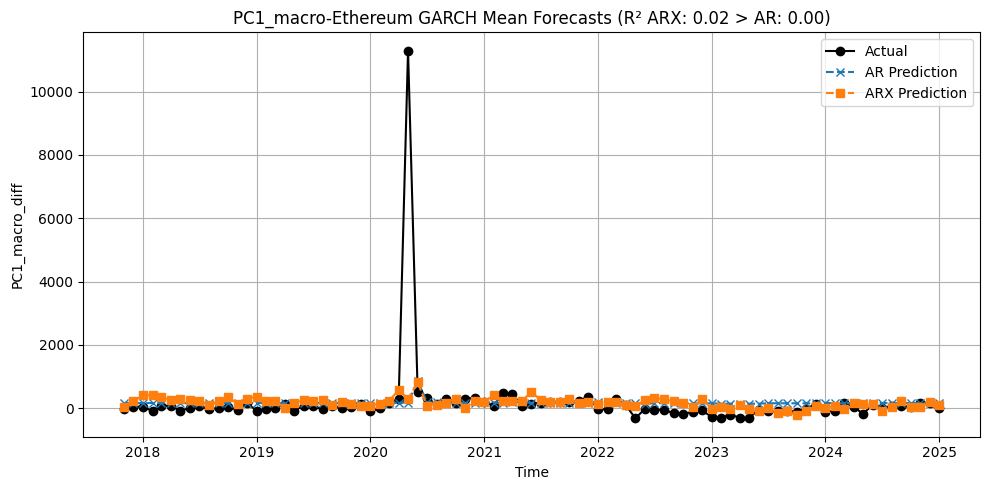

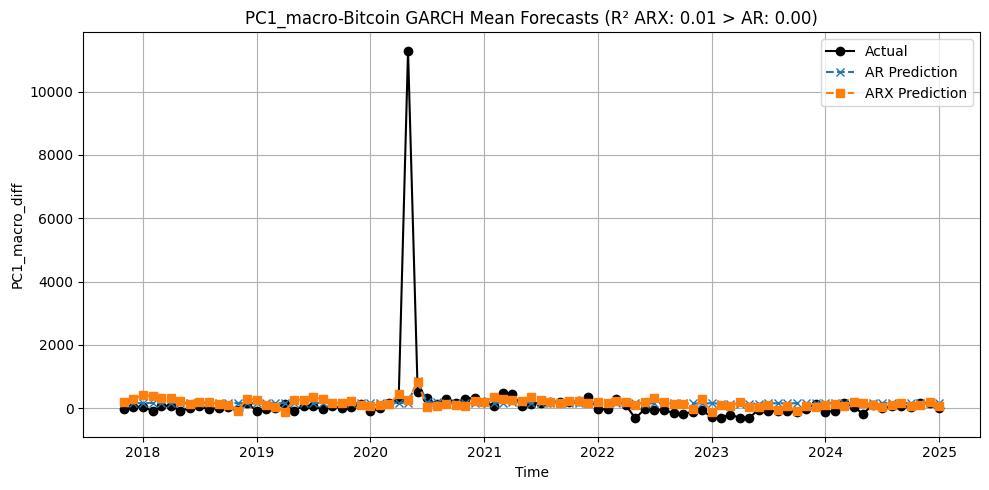

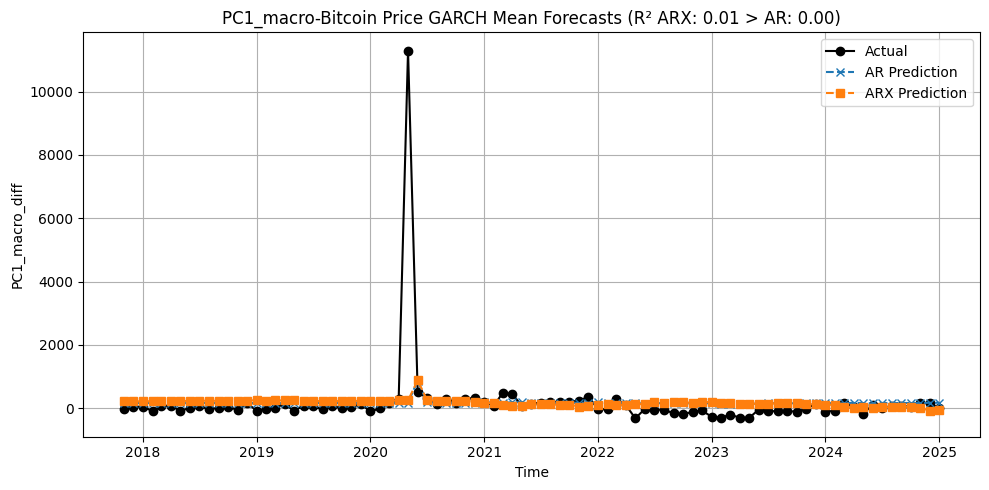

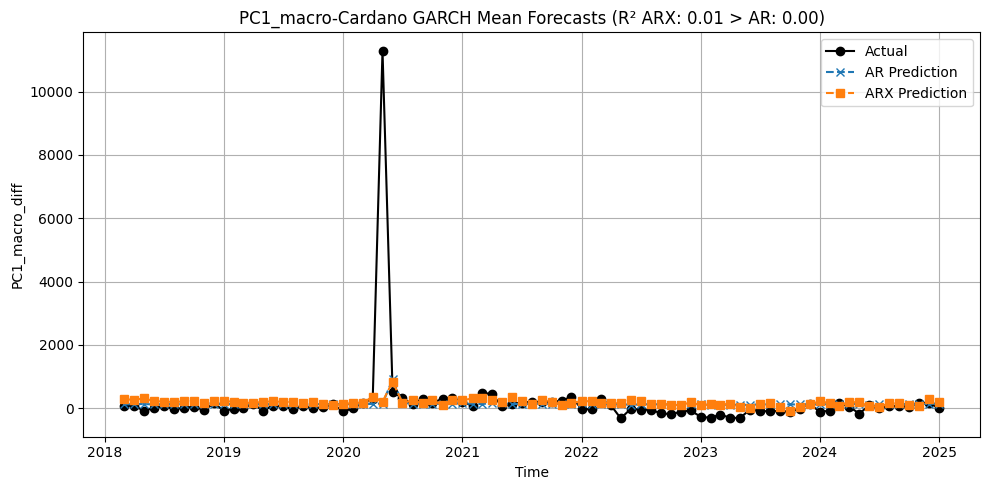

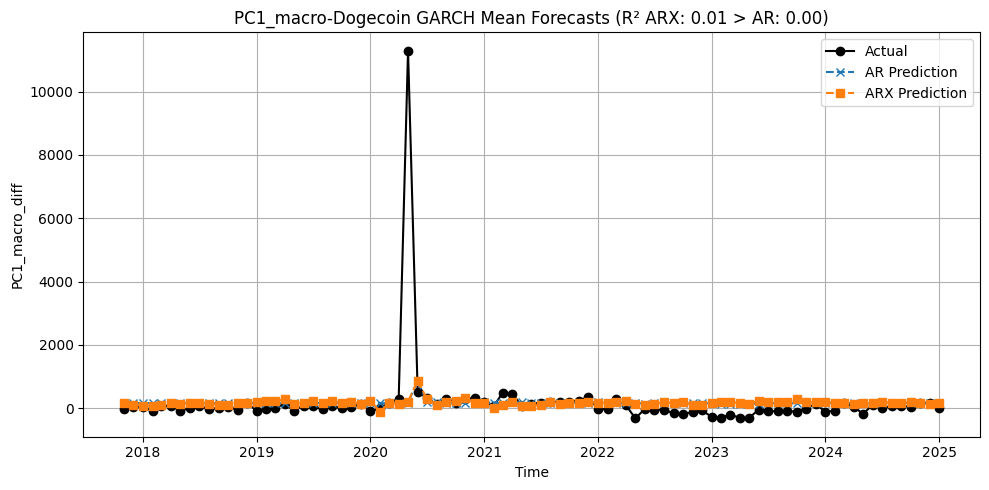

In [67]:
for _, row in results_df_sorted.head(5).iterrows():  # Adjust head(N) as needed
    macro = row['Macro']
    asset = row['Crypto']
    y_col = row['Macro_col']
    p = row['p']
    q = row['q']

    plot_garch_mean_predictions(df, macro, asset, y_col, p, q,
        title_suffix=f"(R² ARX: {row['R2_ARX']:.2f} > AR: {row['R2_AR']:.2f})")


## With test & train- flat bcus using constant-mean forecasts?

In [70]:

def rolling_forecast_ar(y_train_scaled, y_test_scaled, p, q):
    history = list(y_train_scaled)
    preds = []

    for t in range(len(y_test_scaled)):
        model = arch_model(history, mean='AR', lags=1, vol='GARCH', p=p, q=q, dist='normal')
        res = model.fit(disp='off')
        forecast = res.forecast(horizon=1, method='analytic')
        pred = forecast.mean.values[-1, 0]
        preds.append(pred)
        history.append(y_test_scaled[t])  # Add actual value for next iteration

    return np.array(preds)

def rolling_forecast_arx(y_train_scaled, x_train_scaled, y_test_scaled, x_test_scaled, p, q):
    history_y = list(y_train_scaled)
    history_x = list(x_train_scaled)
    preds = []

    for t in range(len(y_test_scaled)):
        x_arr = np.array(history_x)
        model = arch_model(history_y, mean='ARX', lags=1, vol='GARCH', p=p, q=q, x=x_arr, dist='normal')
        res = model.fit(disp='off')

        # Mean forecast = Const + phi * y_t + beta * x_{t+1}
        const = res.params.get('Const', 0)
        phi = res.params.get('y[1]', 0)
        beta = res.params.get('x0', 0)

        y_t = history_y[-1]
        x_t1 = x_test_scaled[t]

        pred = const + phi * y_t + beta * x_t1
        preds.append(pred)

        # Update histories with actuals for next step
        history_y.append(y_test_scaled[t])
        history_x.append(x_test_scaled[t])

    return np.array(preds)

def plot_garch_mean_predictions_rolling(df, macro, asset, y_col, p, q, title_suffix=""):
    df_temp = df[[y_col, asset]].dropna().copy()
    if len(df_temp) < 30:
        print(f"Skipping {macro}-{asset}: insufficient data ({len(df_temp)})")
        return

    train_size = int(len(df_temp) * 0.7)
    df_train = df_temp.iloc[:train_size]
    df_test = df_temp.iloc[train_size:]

    # Scale separately to avoid leakage
    scaler_y = StandardScaler()
    scaler_x = StandardScaler()
    y_train_scaled = scaler_y.fit_transform(df_train[[y_col]]).flatten()
    x_train_scaled = scaler_x.fit_transform(df_train[[asset]]).flatten()
    y_test_scaled = scaler_y.transform(df_test[[y_col]]).flatten()
    x_test_scaled = scaler_x.transform(df_test[[asset]]).flatten()

    try:
        # Rolling forecasts
        pred_ar_scaled = rolling_forecast_ar(y_train_scaled, y_test_scaled, int(p), int(q))
        pred_arx_scaled = rolling_forecast_arx(y_train_scaled, x_train_scaled, y_test_scaled, x_test_scaled, int(p), int(q))

        # Inverse scale
        pred_ar = scaler_y.inverse_transform(pred_ar_scaled.reshape(-1, 1)).flatten()
        pred_arx = scaler_y.inverse_transform(pred_arx_scaled.reshape(-1, 1)).flatten()
        y_actual = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()
        index_test = df_test.index

        # Plot results
        plt.figure(figsize=(10, 5))
        plt.plot(index_test, y_actual, label='Actual (Test)', color='black', marker='o')
        plt.plot(index_test, pred_ar, label='AR Forecast (Rolling)', linestyle='--', marker='x')
        plt.plot(index_test, pred_arx, label='ARX Forecast (Rolling)', linestyle='--', marker='s')
        plt.title(f'{macro}-{asset} GARCH Mean Rolling Forecasts {title_suffix}')
        plt.xlabel('Time')
        plt.ylabel(y_col)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Plotting failed for {macro}-{asset}: {e}")


## Generating MAPE with this new rolling method

MAPE AR: 288.03%, ARX: 300.13%, ARX improvement: -4.20%


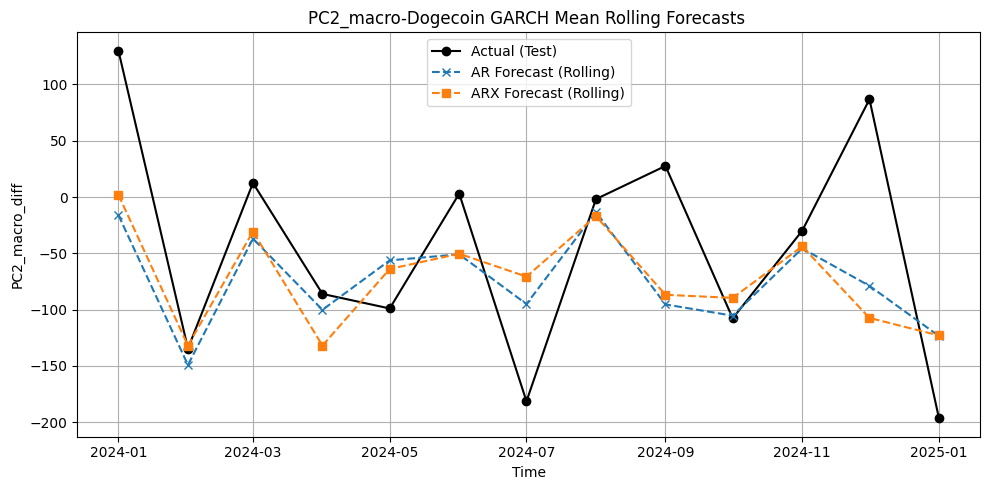

In [79]:
def plot_garch_mean_predictions_rolling(df, macro, asset, y_col, p, q, title_suffix=""):
    df_temp = df[[y_col, asset]].dropna().copy()
    if len(df_temp) < 30:
        print(f"Skipping {macro}-{asset}: insufficient data ({len(df_temp)})")
        return

    train_size = int(len(df_temp) * 0.86)
    df_train = df_temp.iloc[:train_size]
    df_test = df_temp.iloc[train_size:]

    # Scale separately to avoid leakage
    scaler_y = StandardScaler()
    scaler_x = StandardScaler()
    y_train_scaled = scaler_y.fit_transform(df_train[[y_col]]).flatten()
    x_train_scaled = scaler_x.fit_transform(df_train[[asset]]).flatten()
    y_test_scaled = scaler_y.transform(df_test[[y_col]]).flatten()
    x_test_scaled = scaler_x.transform(df_test[[asset]]).flatten()

    try:
        # Rolling forecasts
        pred_ar_scaled = rolling_forecast_ar(y_train_scaled, y_test_scaled, int(p), int(q))
        pred_arx_scaled = rolling_forecast_arx(
            y_train_scaled, x_train_scaled, y_test_scaled, x_test_scaled, int(p), int(q)
        )

        # Inverse scale
        pred_ar = scaler_y.inverse_transform(pred_ar_scaled.reshape(-1, 1)).flatten()
        pred_arx = scaler_y.inverse_transform(pred_arx_scaled.reshape(-1, 1)).flatten()
        y_actual = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()
        index_test = df_test.index

        # ✅ Compute MAPE values
        def safe_mape(actual, predicted):
            actual, predicted = np.array(actual), np.array(predicted)
            mask = actual != 0
            return np.mean(np.abs((actual[mask] - predicted[mask]) / actual[mask])) * 100 if np.any(mask) else np.nan

        mape_ar = safe_mape(y_actual, pred_ar)
        mape_arx = safe_mape(y_actual, pred_arx)
        mape_change = ((mape_ar - mape_arx) / mape_ar) * 100 if mape_ar != 0 else np.nan

        print(f"MAPE AR: {mape_ar:.2f}%, ARX: {mape_arx:.2f}%, ARX improvement: {mape_change:.2f}%")

        # Plot results
        plt.figure(figsize=(10, 5))
        plt.plot(index_test, y_actual, label='Actual (Test)', color='black', marker='o')
        plt.plot(index_test, pred_ar, label='AR Forecast (Rolling)', linestyle='--', marker='x')
        plt.plot(index_test, pred_arx, label='ARX Forecast (Rolling)', linestyle='--', marker='s')
        plt.title(f'{macro}-{asset} GARCH Mean Rolling Forecasts {title_suffix}')
        plt.xlabel('Time')
        plt.ylabel(y_col)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Plotting failed for {macro}-{asset}: {e}")

plot_garch_mean_predictions_rolling(df, 'PC2_macro', 'Dogecoin', 'PC2_macro_diff', 4, 1)


In [81]:
def safe_mape(actual, predicted):
    actual, predicted = np.array(actual), np.array(predicted)
    mask = actual != 0
    return np.mean(np.abs((actual[mask] - predicted[mask]) / actual[mask])) * 100 if np.any(mask) else np.nan

def loop_garch_plot_and_collect_improvement(df, macro_list, crypto_list, p=1, q=1, suppress_plot=False):
    mape_improvement_table = pd.DataFrame(index=macro_list, columns=crypto_list)

    for macro in macro_list:
        if f'{macro}_diff_diff' in df.columns:
            y_col = f'{macro}_diff_diff'
        elif f'{macro}_diff' in df.columns:
            y_col = f'{macro}_diff'
        else:
            y_col = macro

        for crypto in crypto_list:
            df_temp = df[[y_col, crypto]].dropna().copy()
            if len(df_temp) < 30:
                print(f"Skipping {macro}-{crypto}: insufficient data ({len(df_temp)})")
                continue

            train_size = int(len(df_temp) * 0.86)
            df_train = df_temp.iloc[:train_size]
            df_test = df_temp.iloc[train_size:]

            scaler_y = StandardScaler()
            scaler_x = StandardScaler()
            y_train_scaled = scaler_y.fit_transform(df_train[[y_col]]).flatten()
            x_train_scaled = scaler_x.fit_transform(df_train[[crypto]]).flatten()
            y_test_scaled = scaler_y.transform(df_test[[y_col]]).flatten()
            x_test_scaled = scaler_x.transform(df_test[[crypto]]).flatten()

            try:
                # Forecasts
                pred_ar_scaled = rolling_forecast_ar(y_train_scaled, y_test_scaled, p, q)
                pred_arx_scaled = rolling_forecast_arx(
                    y_train_scaled, x_train_scaled, y_test_scaled, x_test_scaled, p, q
                )

                # Inverse scale
                pred_ar = scaler_y.inverse_transform(pred_ar_scaled.reshape(-1, 1)).flatten()
                pred_arx = scaler_y.inverse_transform(pred_arx_scaled.reshape(-1, 1)).flatten()
                y_actual = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()

                # MAPE calc
                mape_ar = safe_mape(y_actual, pred_ar)
                mape_arx = safe_mape(y_actual, pred_arx)
                mape_change = ((mape_ar - mape_arx) / mape_ar) * 100 if mape_ar != 0 else np.nan

                # Print and plot
                print(f"{macro}-{crypto} | MAPE AR: {mape_ar:.2f}%, ARX: {mape_arx:.2f}%, ARX improvement: {mape_change:.2f}%")
                mape_improvement_table.loc[macro, crypto] = round(mape_change, 2)

                if not suppress_plot:
                    index_test = df_test.index
                    plt.figure(figsize=(10, 5))
                    plt.plot(index_test, y_actual, label='Actual', color='black', marker='o')
                    plt.plot(index_test, pred_ar, label='AR', linestyle='--', marker='x')
                    plt.plot(index_test, pred_arx, label='ARX', linestyle='--', marker='s')
                    plt.title(f'{macro}-{crypto} GARCH Mean Rolling Forecasts')
                    plt.xlabel('Time')
                    plt.ylabel(y_col)
                    plt.legend()
                    plt.grid(True)
                    plt.tight_layout()
                    plt.show()

            except Exception as e:
                print(f"Failed on {macro}-{crypto}: {e}")
                continue

    return mape_improvement_table.fillna(0)

macro_list = ['PC1_macro','PC2_macro']
crypto_list = ['Bitcoin', 'Tether', 'Litecoin', 'XRP', 'Ethereum', 'Dogecoin', 'Cardano', 'USD Coin']

mape_change_table = loop_garch_plot_and_collect_improvement(df, macro_list, crypto_list, p=1, q=1, suppress_plot=True)
display(mape_change_table)


PC1_macro-Bitcoin | MAPE AR: 1583.72%, ARX: 639.78%, ARX improvement: 59.60%
PC1_macro-Tether | MAPE AR: 1583.72%, ARX: 1564.85%, ARX improvement: 1.19%
PC1_macro-Litecoin | MAPE AR: 1583.72%, ARX: 1645.98%, ARX improvement: -3.93%
PC1_macro-XRP | MAPE AR: 1583.72%, ARX: 1709.02%, ARX improvement: -7.91%
PC1_macro-Ethereum | MAPE AR: 1583.72%, ARX: 971.54%, ARX improvement: 38.65%
PC1_macro-Dogecoin | MAPE AR: 1583.72%, ARX: 1801.96%, ARX improvement: -13.78%
PC1_macro-Cardano | MAPE AR: 1674.58%, ARX: 1028.25%, ARX improvement: 38.60%
PC1_macro-USD Coin | MAPE AR: 2241.67%, ARX: 1961.64%, ARX improvement: 12.49%
PC2_macro-Bitcoin | MAPE AR: 254.31%, ARX: 328.85%, ARX improvement: -29.31%
PC2_macro-Tether | MAPE AR: 254.31%, ARX: 282.82%, ARX improvement: -11.21%
PC2_macro-Litecoin | MAPE AR: 254.31%, ARX: 367.49%, ARX improvement: -44.51%
PC2_macro-XRP | MAPE AR: 254.31%, ARX: 282.29%, ARX improvement: -11.00%
PC2_macro-Ethereum | MAPE AR: 254.31%, ARX: 337.09%, ARX improvement: -32.5

/var/folders/91/zhth7_q95v1c0mrzzznv18_w0000gn/T/ipykernel_44451/3280745863.py:73: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return mape_improvement_table.fillna(0)


,Bitcoin,Tether,Litecoin,XRP,Ethereum,Dogecoin,Cardano,USD Coin
PC1_macro,59.60,1.19,-3.93,-7.91,38.65,-13.78,38.60,12.49
PC2_macro,-29.31,-11.21,-44.51,-11.00,-32.55,-89.77,-26.51,-9.91
